<img src="ost_logo.png" width="240" height="240" align="right"/>
<div style="text-align: left"> <b> Machine Learning </b> <br> MSE FTP MachLe <br> 
<a href="mailto:christoph.wuersch@ost.ch"> Christoph Würsch </a> </div>

# Lab 7, A1 Prediction of City Bike Usage

*First, we define some default parameters for nice plots*

In [1]:
%matplotlib inline

from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize']=6
plt.rcParams['ytick.labelsize']=6

np.set_printoptions(precision=3, suppress=True)

/var/folders/ft/p6xwtlq12ygfhmnytl1ngxdm0000gn/T/ipykernel_8957/1121524485.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'png')


## (a) Reading the City Bike dataset from a pickle file

Citibike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: <pandas._libs.properties.CachedProperty object at 0x129757240>, Name: one, dtype: int64


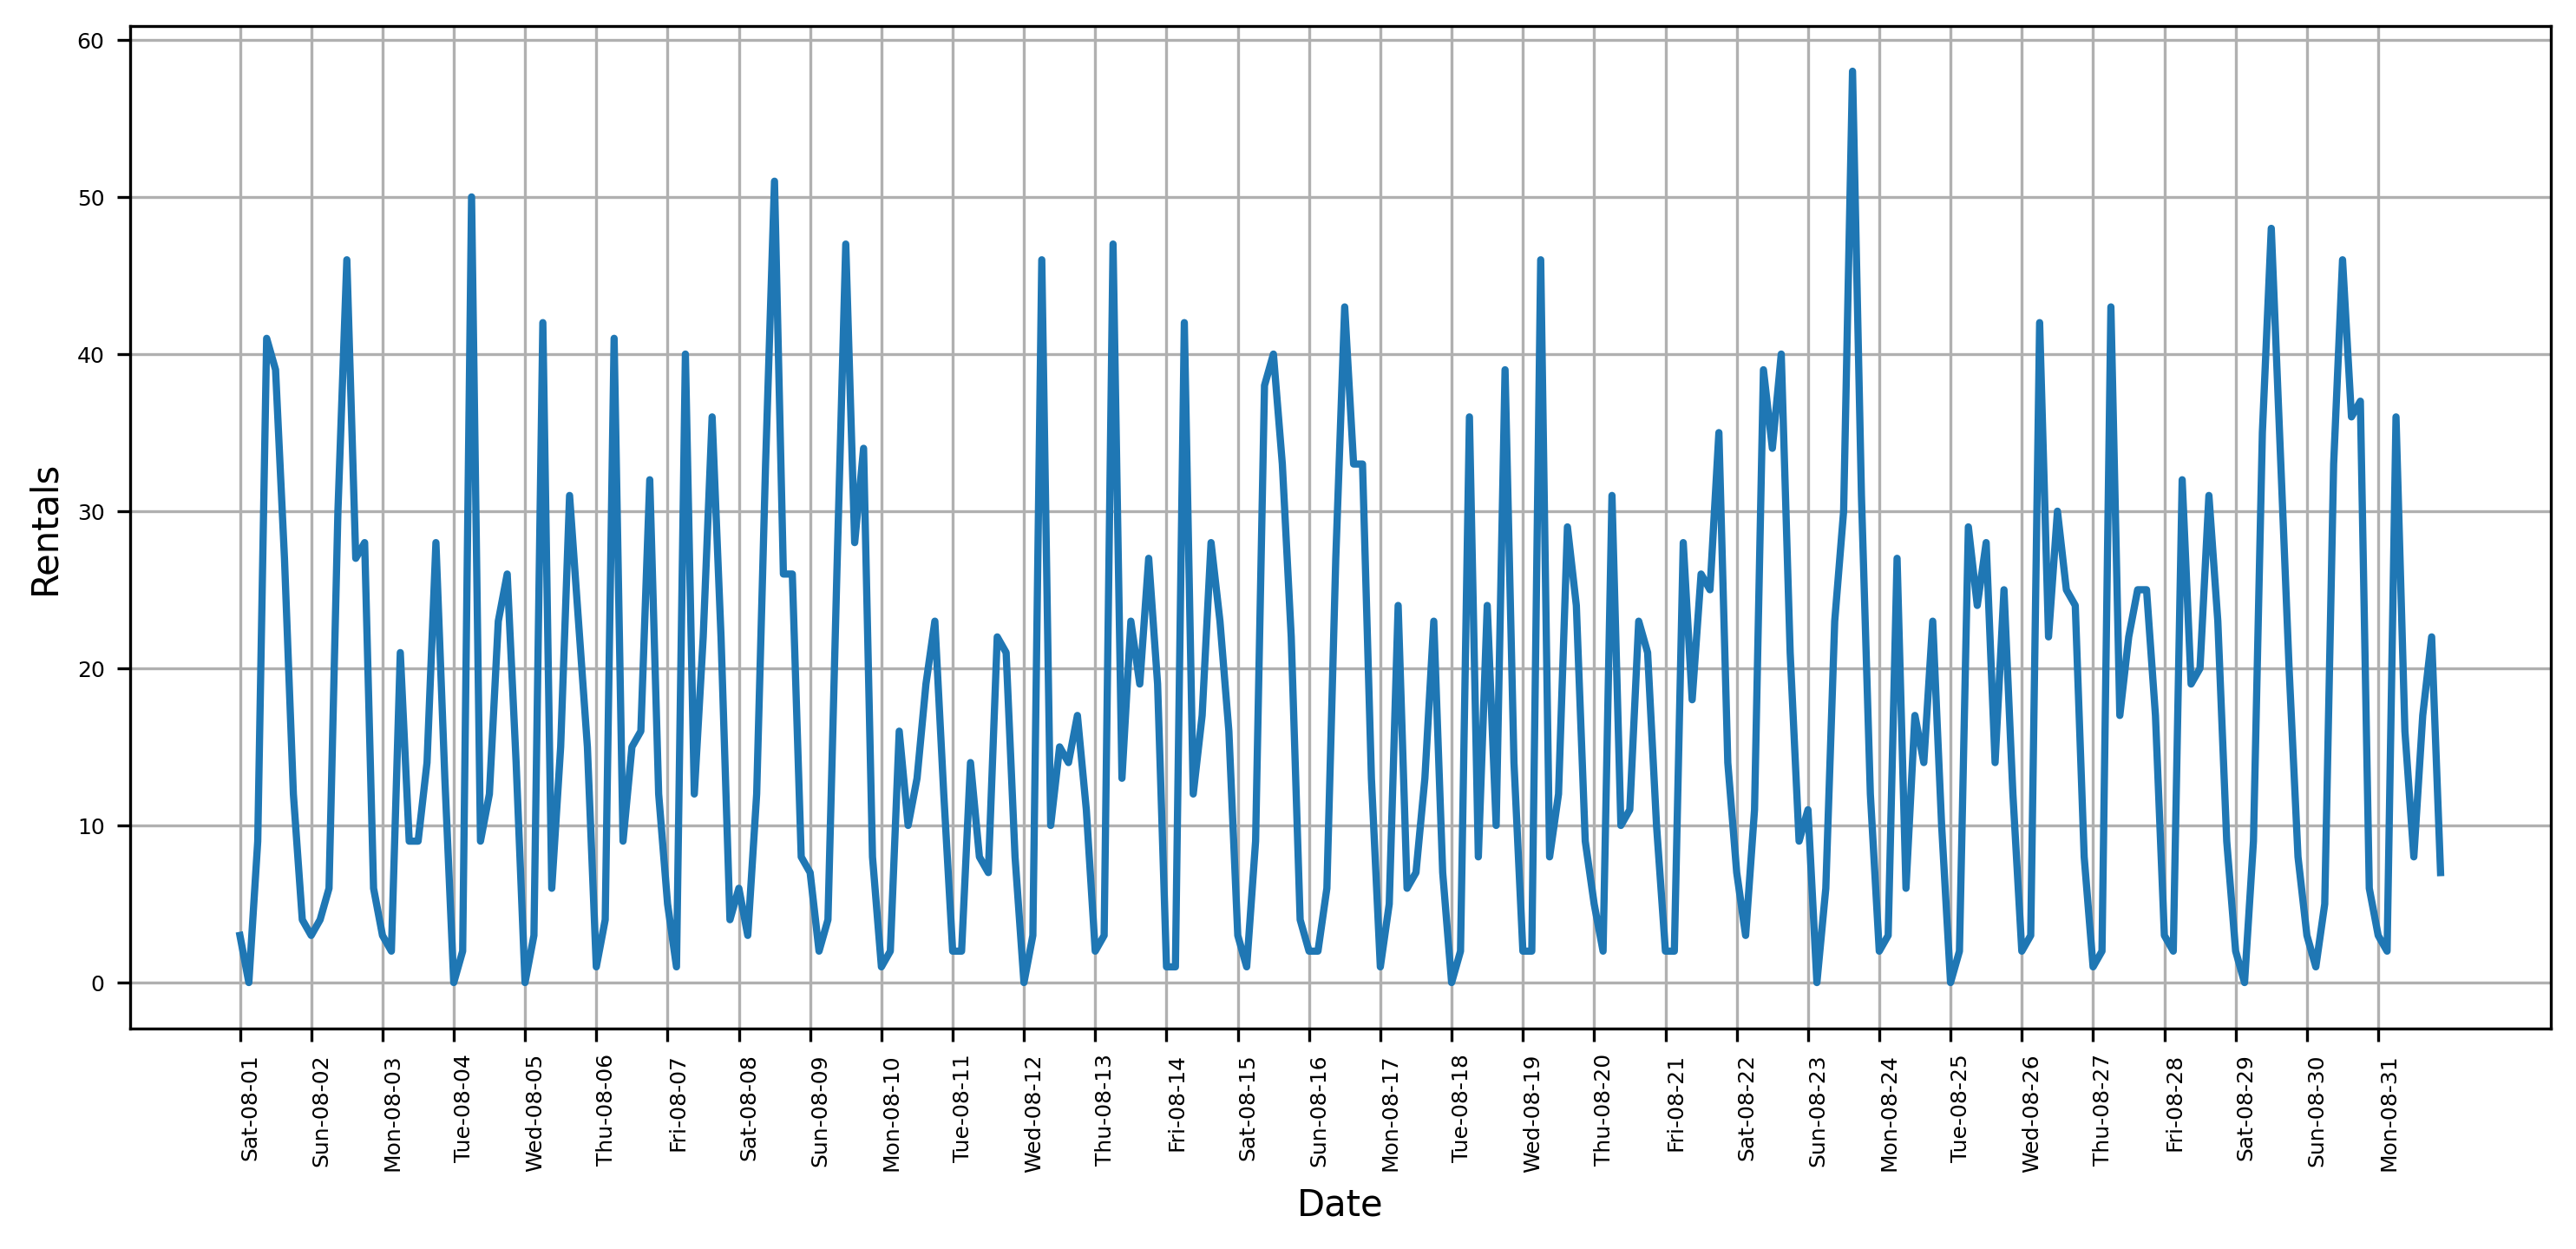

In [2]:
citibike=pd.read_pickle('CitibikeDataSet.pkl')
print("Citibike data:\n{}".format(citibike.head()))

plt.figure(figsize=(12, 5))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks.astype("int"), xticks.strftime("%a-%m-%d"), rotation=90, ha="left")
plt.plot(citibike.index.astype("int"),citibike, linewidth=2)
plt.xlabel("Date")
plt.ylabel("Rentals")
plt.grid(True)


 In Input [4], the time stamp ``citibike.index`` is converted into seconds since 1970 (unix or POSIX time,
c.f. https://en.wikipedia.org/wiki/Unix_time.)

In [3]:
# extract the target values (number of rentals)
y = citibike.values
# convert to POSIX time by dividing by 10**9
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

## (b) eval on features
splits the data into a training and a test set, fits the response y as function of x with a given method (regressor), plots the regression and the predicted output on the training and the test dataset. The regression score is printed to the console.

In [4]:
# use the first 184 data points for training, the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array 
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

## (c) Ensemble Tree Regression on time stamp in seconds
Use as a first model input the time in seconds X and as a response y the number of rentals within the three hour
interval. Use as regressor the ``RandomForestRegressor`` from ``sklearn.ensemble`` using 100
trees. Train and plot the prediction of the regression model using the eval_on_features
function.

Test-set R^2: -0.04


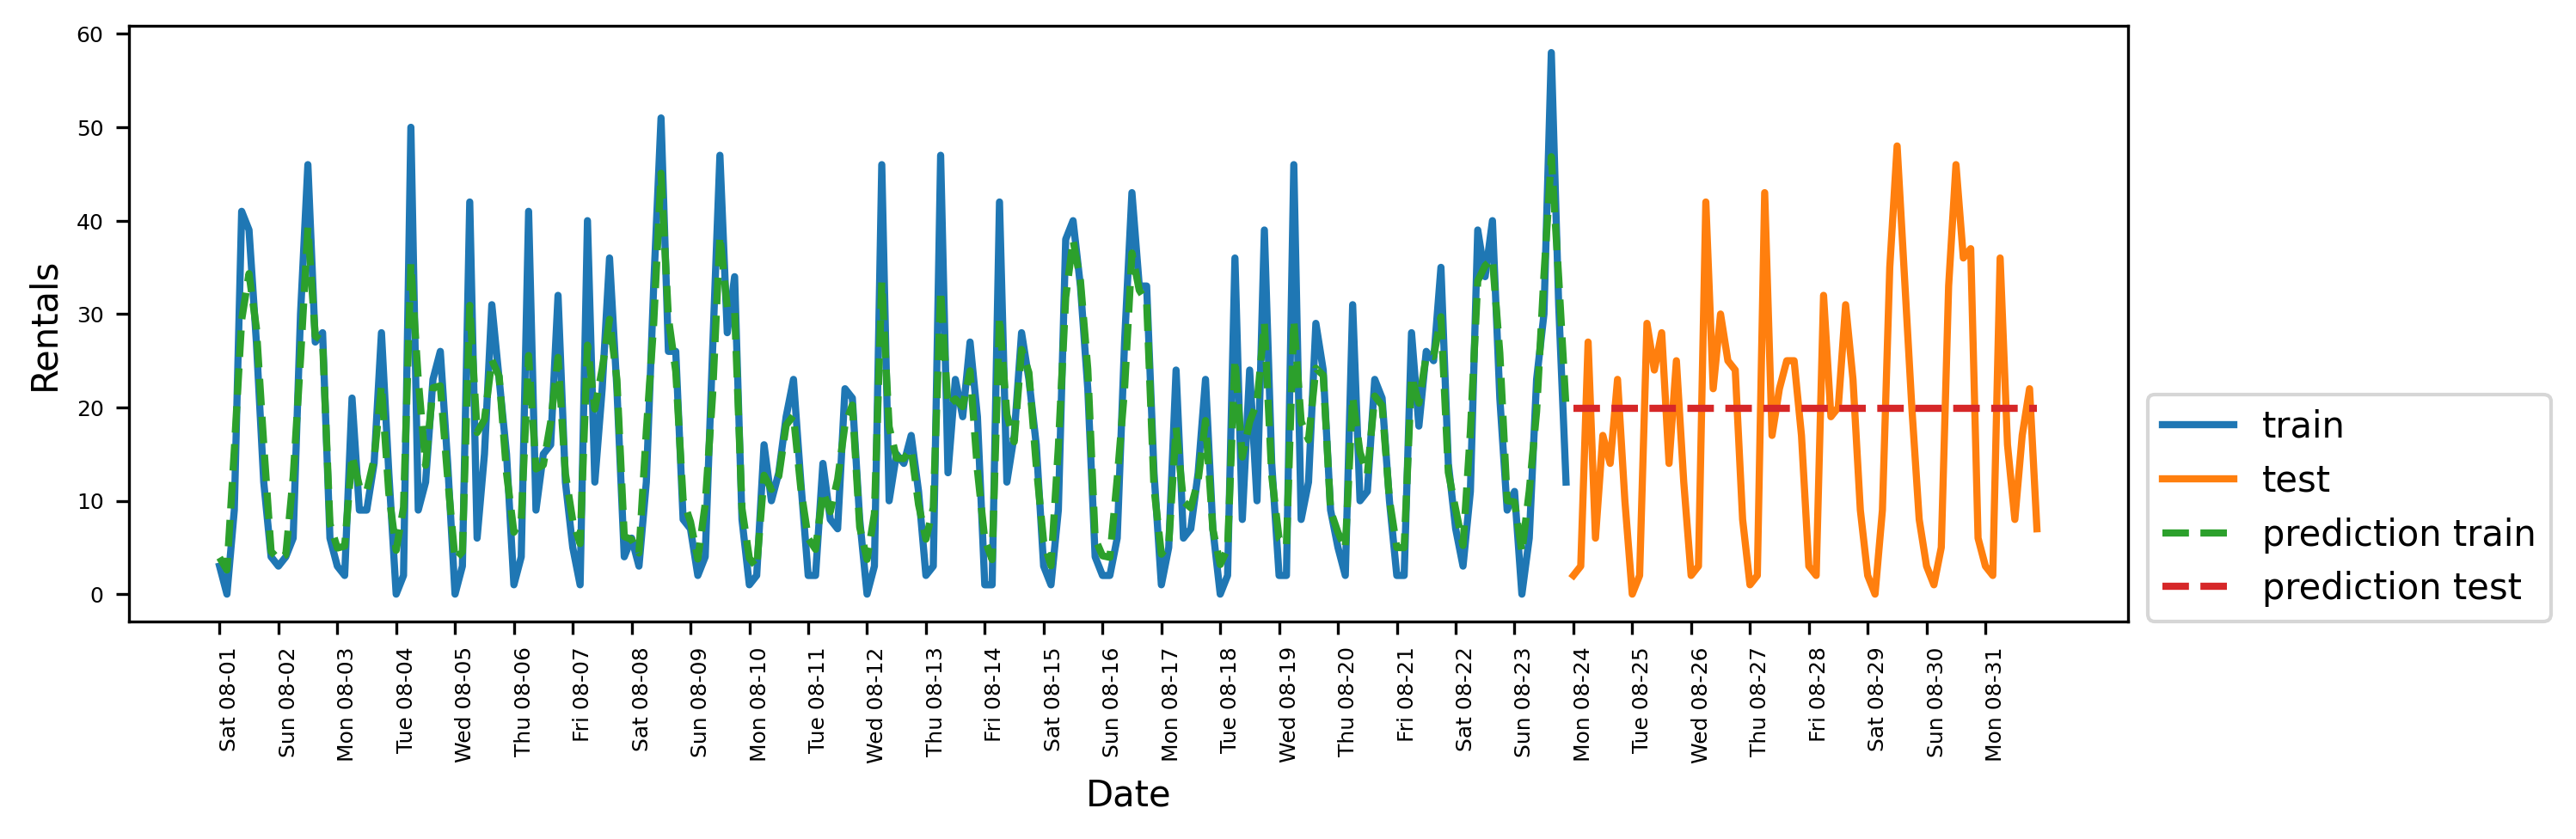

In [5]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

The predictions on the training data are pretty good, as it is for Random Forests is typical, however. However, a constant line is predicted for the test data. The R2 value is -0.04, which means that we have learned nothing. What happened?

The problem is __combining our feature with Random Forest__. The value of the POSIX time for the test data is outside the range of the values of the Training data record: All points in the test data record have later time stamps than all points in the training dataset. __Trees and with it Random Forests cannot extrapolate to values for characteristics outside the training data to map__. As a result, the model simply says the value for the next point in the training dataset before - because this is the last point in time to who has any data at all.


## (d) Use the daytime in hours as an input for the model:

Of course we can improve the model. This is where our "expert knowledge" comes in into the game. When looking at the rental figures in the training dataset we see that two factors are decisive: the time of day and the day of the week.
We can't really do anything with POSIX time, so discard it.
At first we only try the time of day. 



In [6]:

X_hour = citibike.index.hour.values.reshape(-1, 1)



Test-set R^2: 0.60


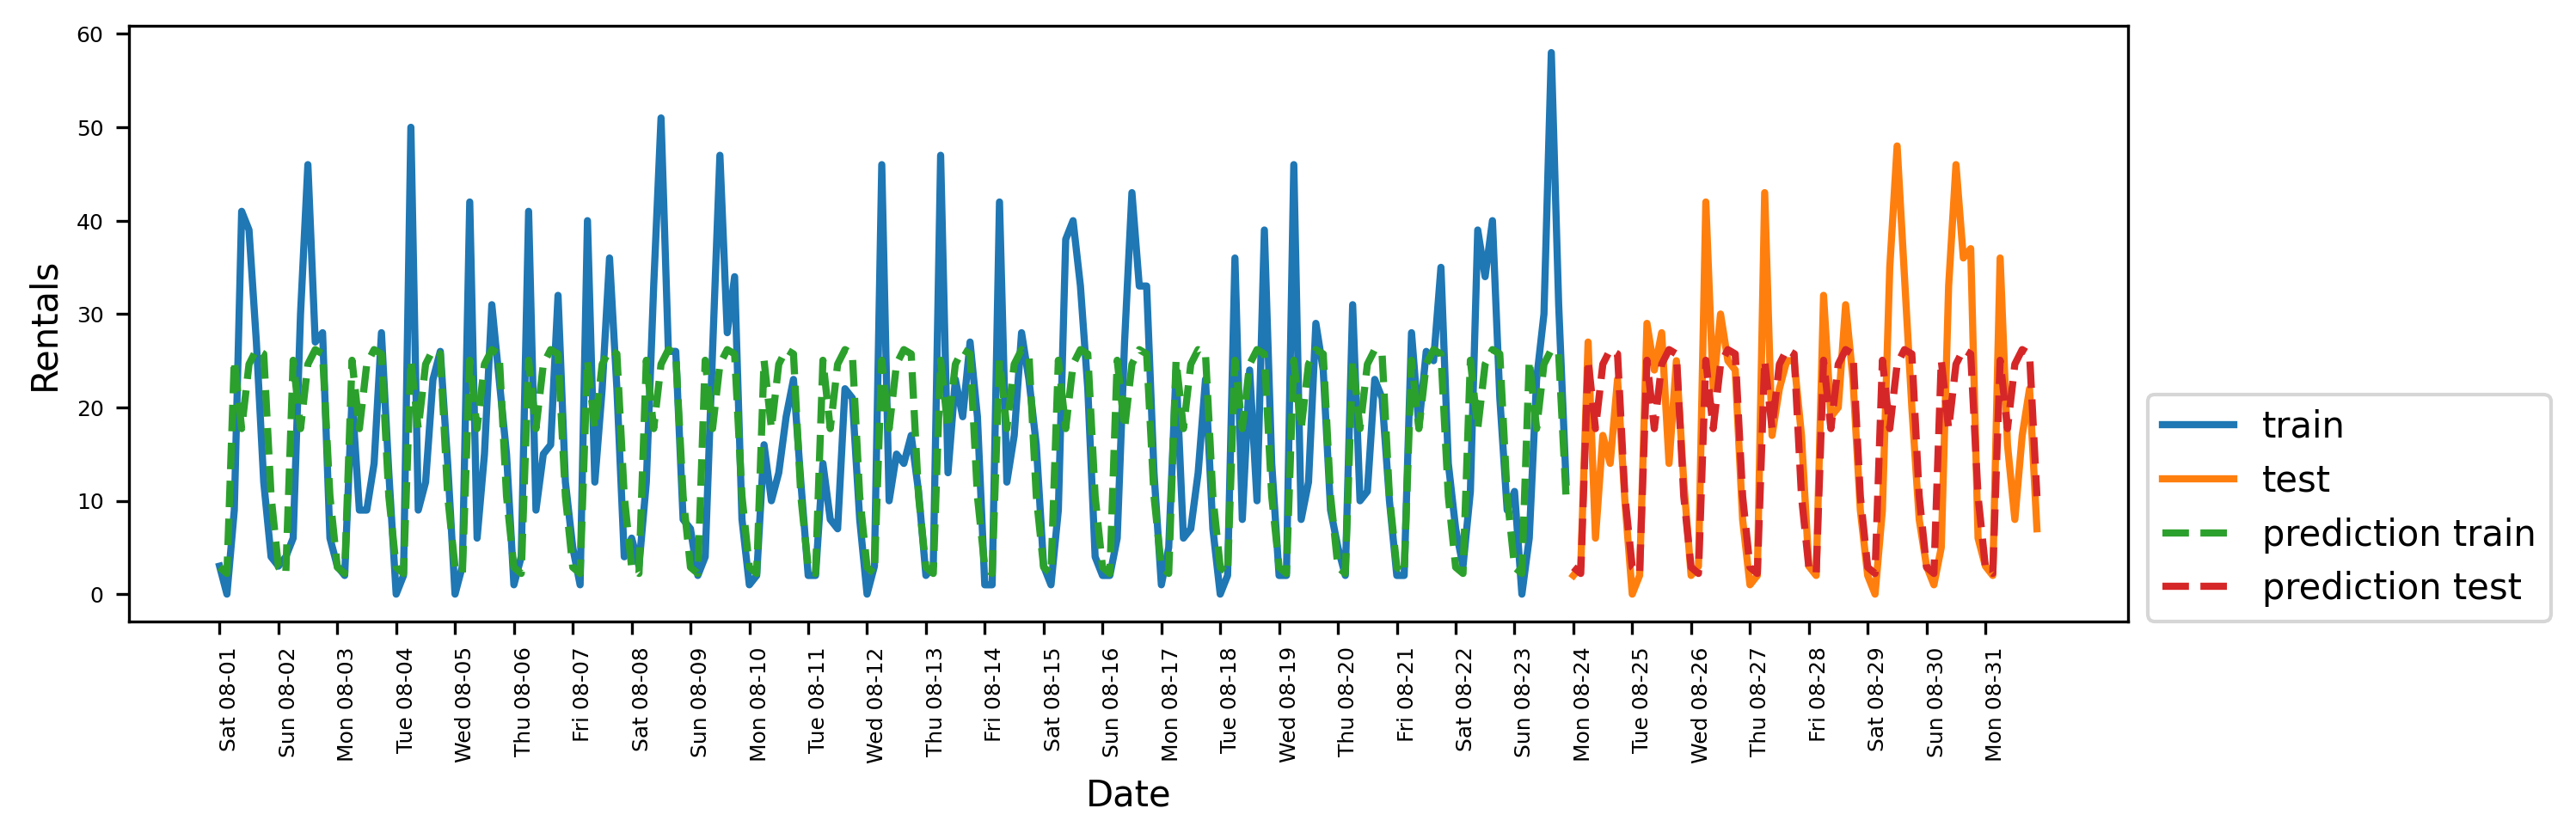

In [7]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_hour, y, regressor)

The R2 value is already much better, but the predictions do not reflect the weekly rhythm. 
So we also add the day of the week.

## (e) Regression on weekday and hour of the day

Test-set R^2: 0.84


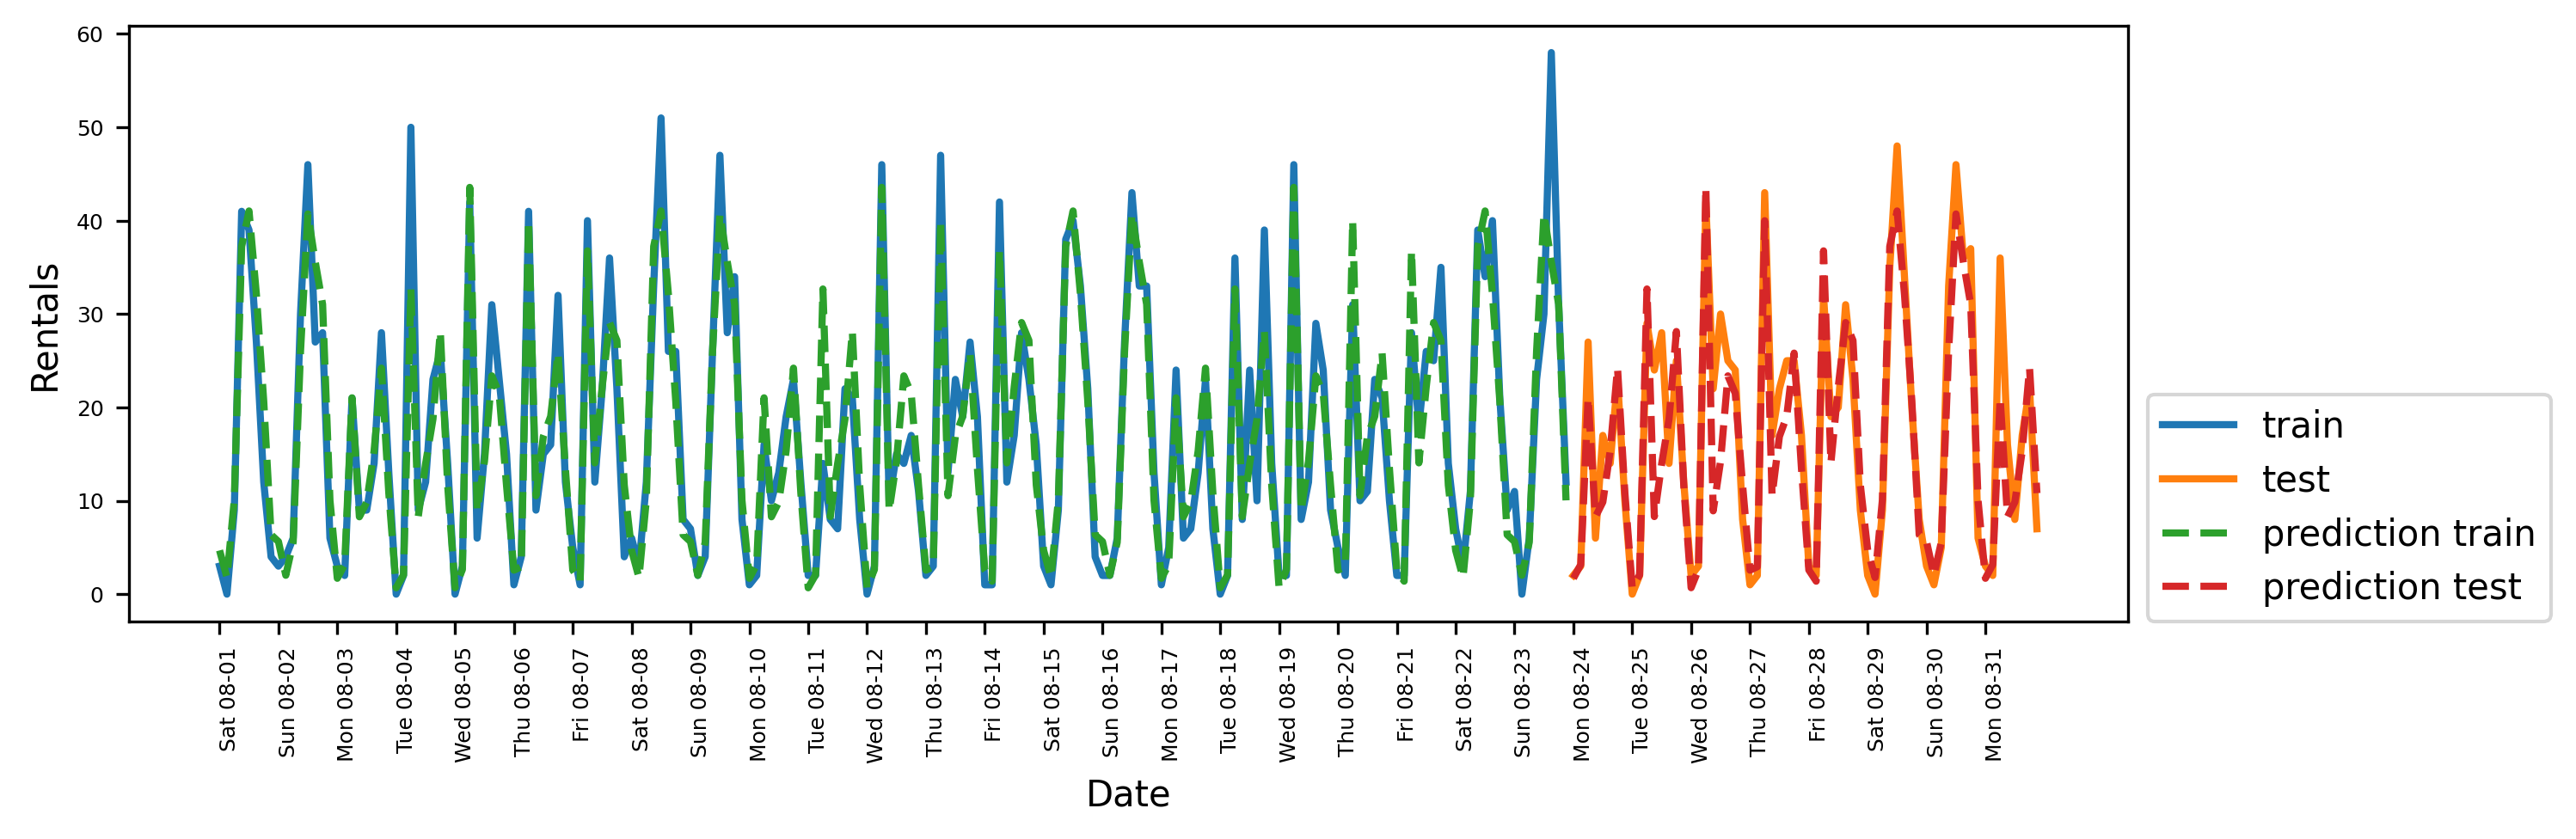

In [8]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)


X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Now we have a model that takes the periodic behavior by considering of weekday and time of day. It has an R2 value of 0.84 and has a a quite good prediction quality. Most likely, this model learns the average number of rentals for any combination of weekday and time of day from the first 23 days in August. This does not actually require a complex model like a Random Forest, so we try as a simpler model LinearRegression:


## (d) Linear Regression on weekday and hour

Test-set R^2: 0.13


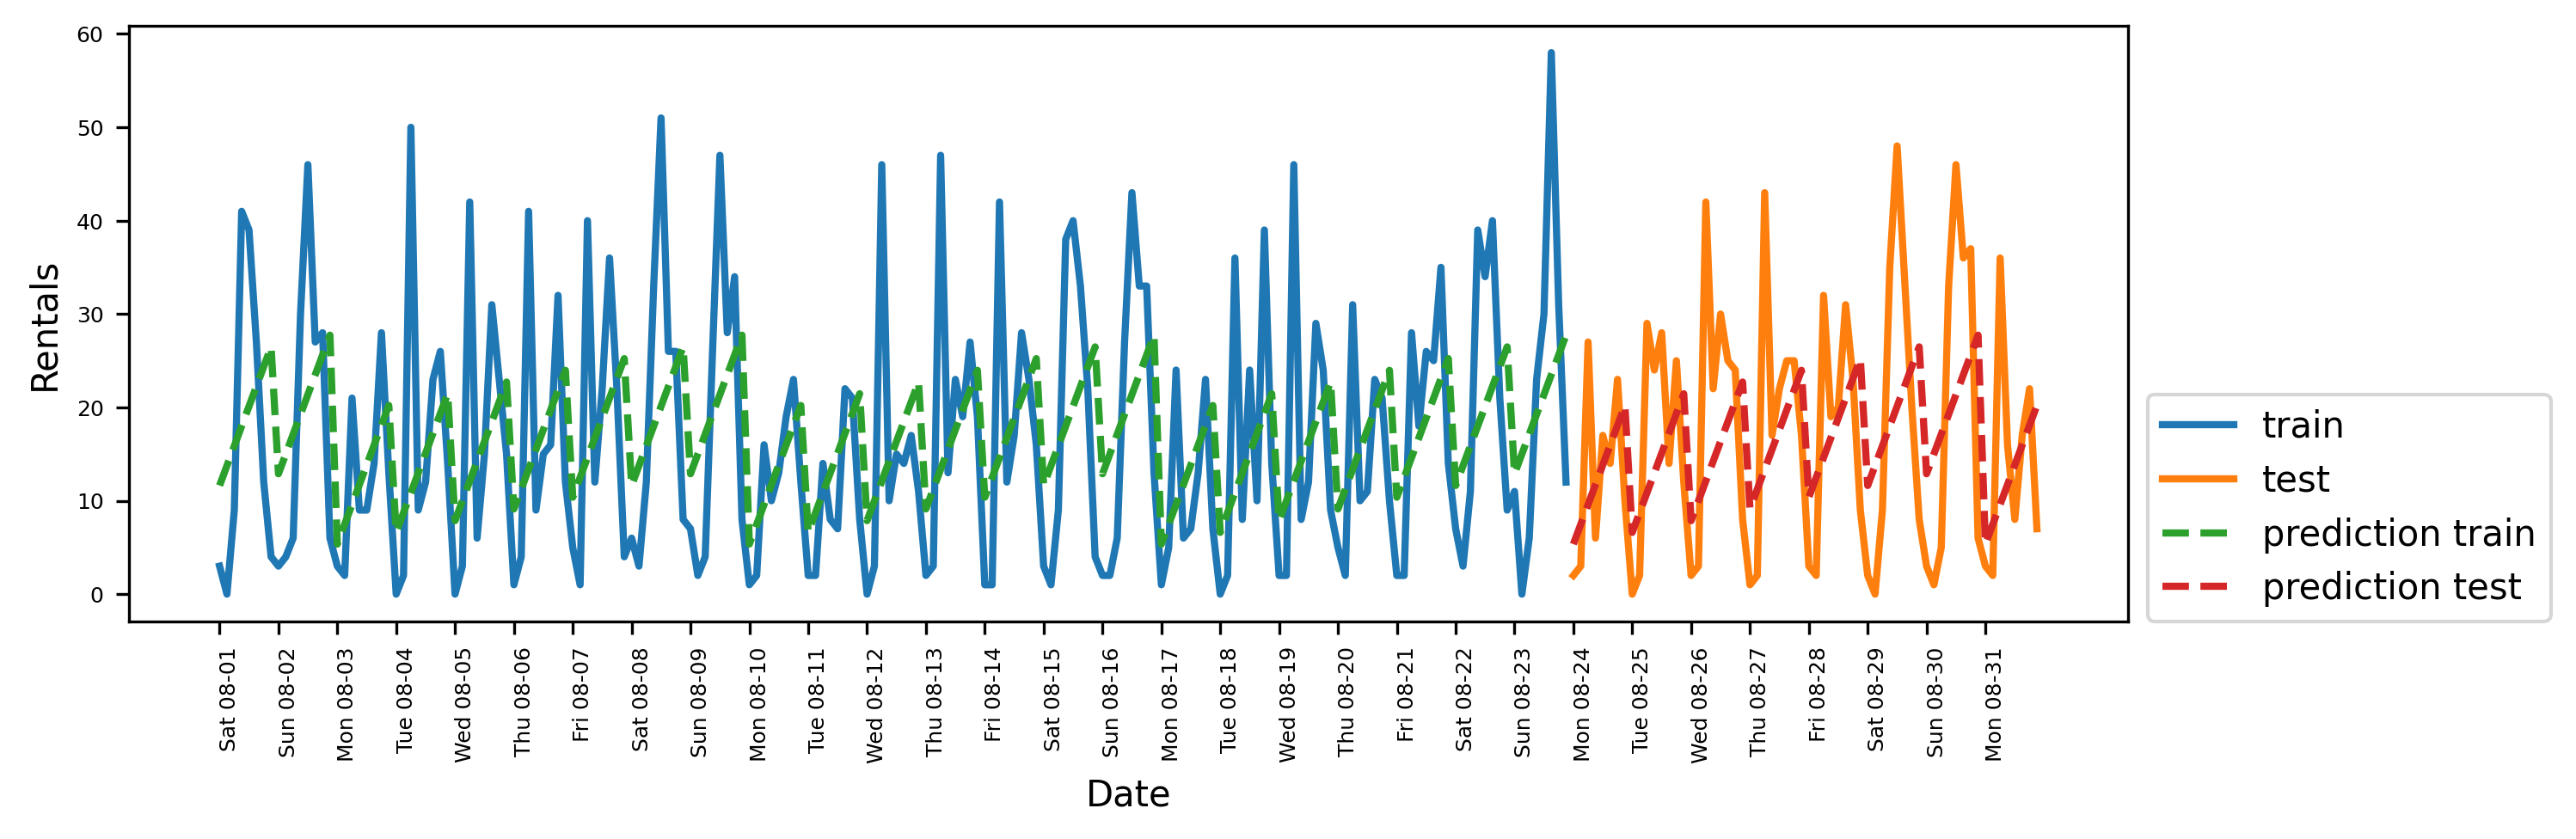

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

eval_on_features(X_hour_week, y, LinearRegression())

Result: LinearRegression works much worse, and the periodicity looks odd. The reason for this is that we use the day of the week and the time as numbers which are __interpreted as continuous variables__. Therefore the linear model only learns a linear function of the time of day - and it has learned that there are more rentals at later times of the day. However the real patterns are far more complex. We can grasp this by looking at the Integer numbers as categorical variables and use them with the ``OneHotEncoder`` transform 

## (g) One-hot-Encoding of weekday and hour

Now we apply the one-hot-encoding to the day and week.

Test-set R^2: 0.62


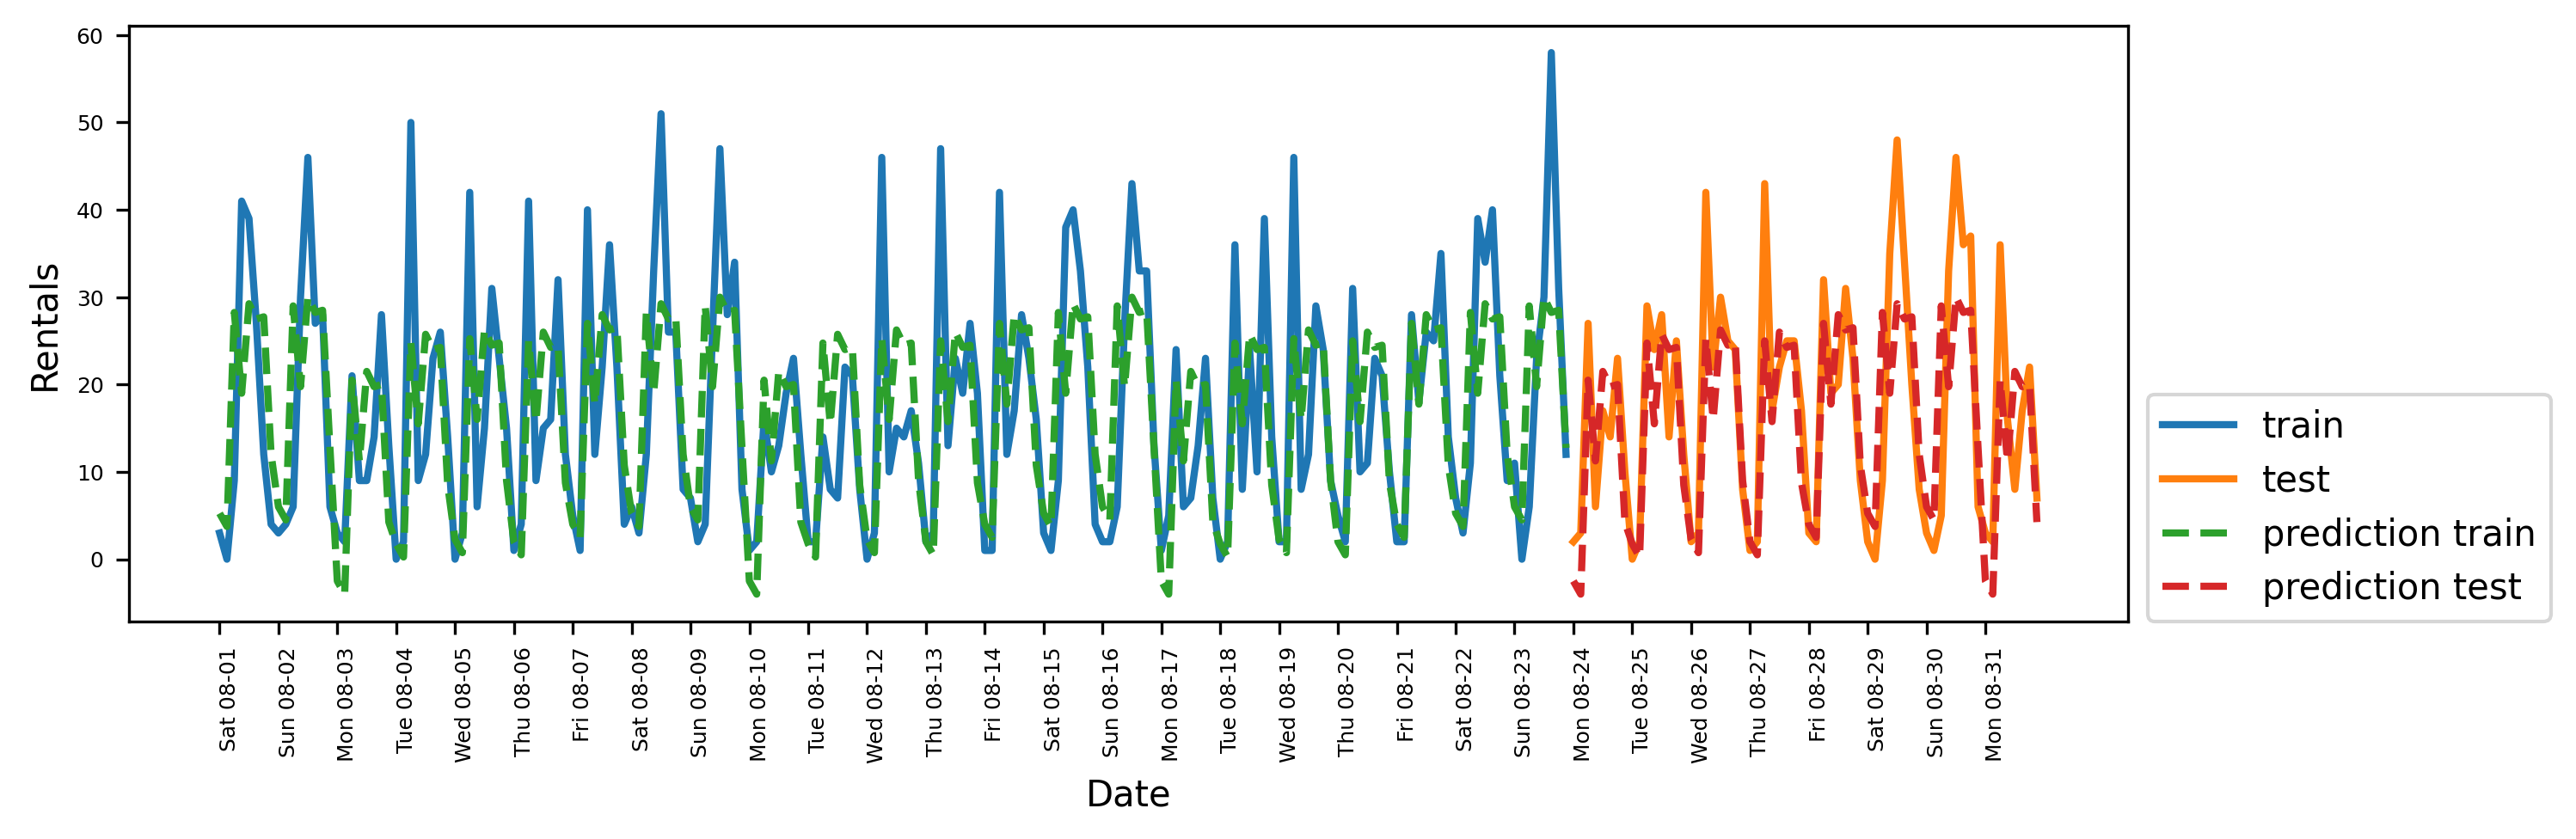

In [10]:
from sklearn.preprocessing import OneHotEncoder
# transform using the OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, LinearRegression())

In [11]:
print(X_hour_week_onehot.shape)

(248, 15)


We get a much better match than with the continuously coded feature. Now the linear model learns one coefficient per weekday Now the linear model learns a coefficient for each weekday and one per time of day. This means, however, that the "time of day periodicity" is is spread over all days of the week.

## (h) Polynomial Feature Generation

With interaction features, we can define a coefficient for each combination of day of the week and time of day in the model.

Test-set R^2: 0.85


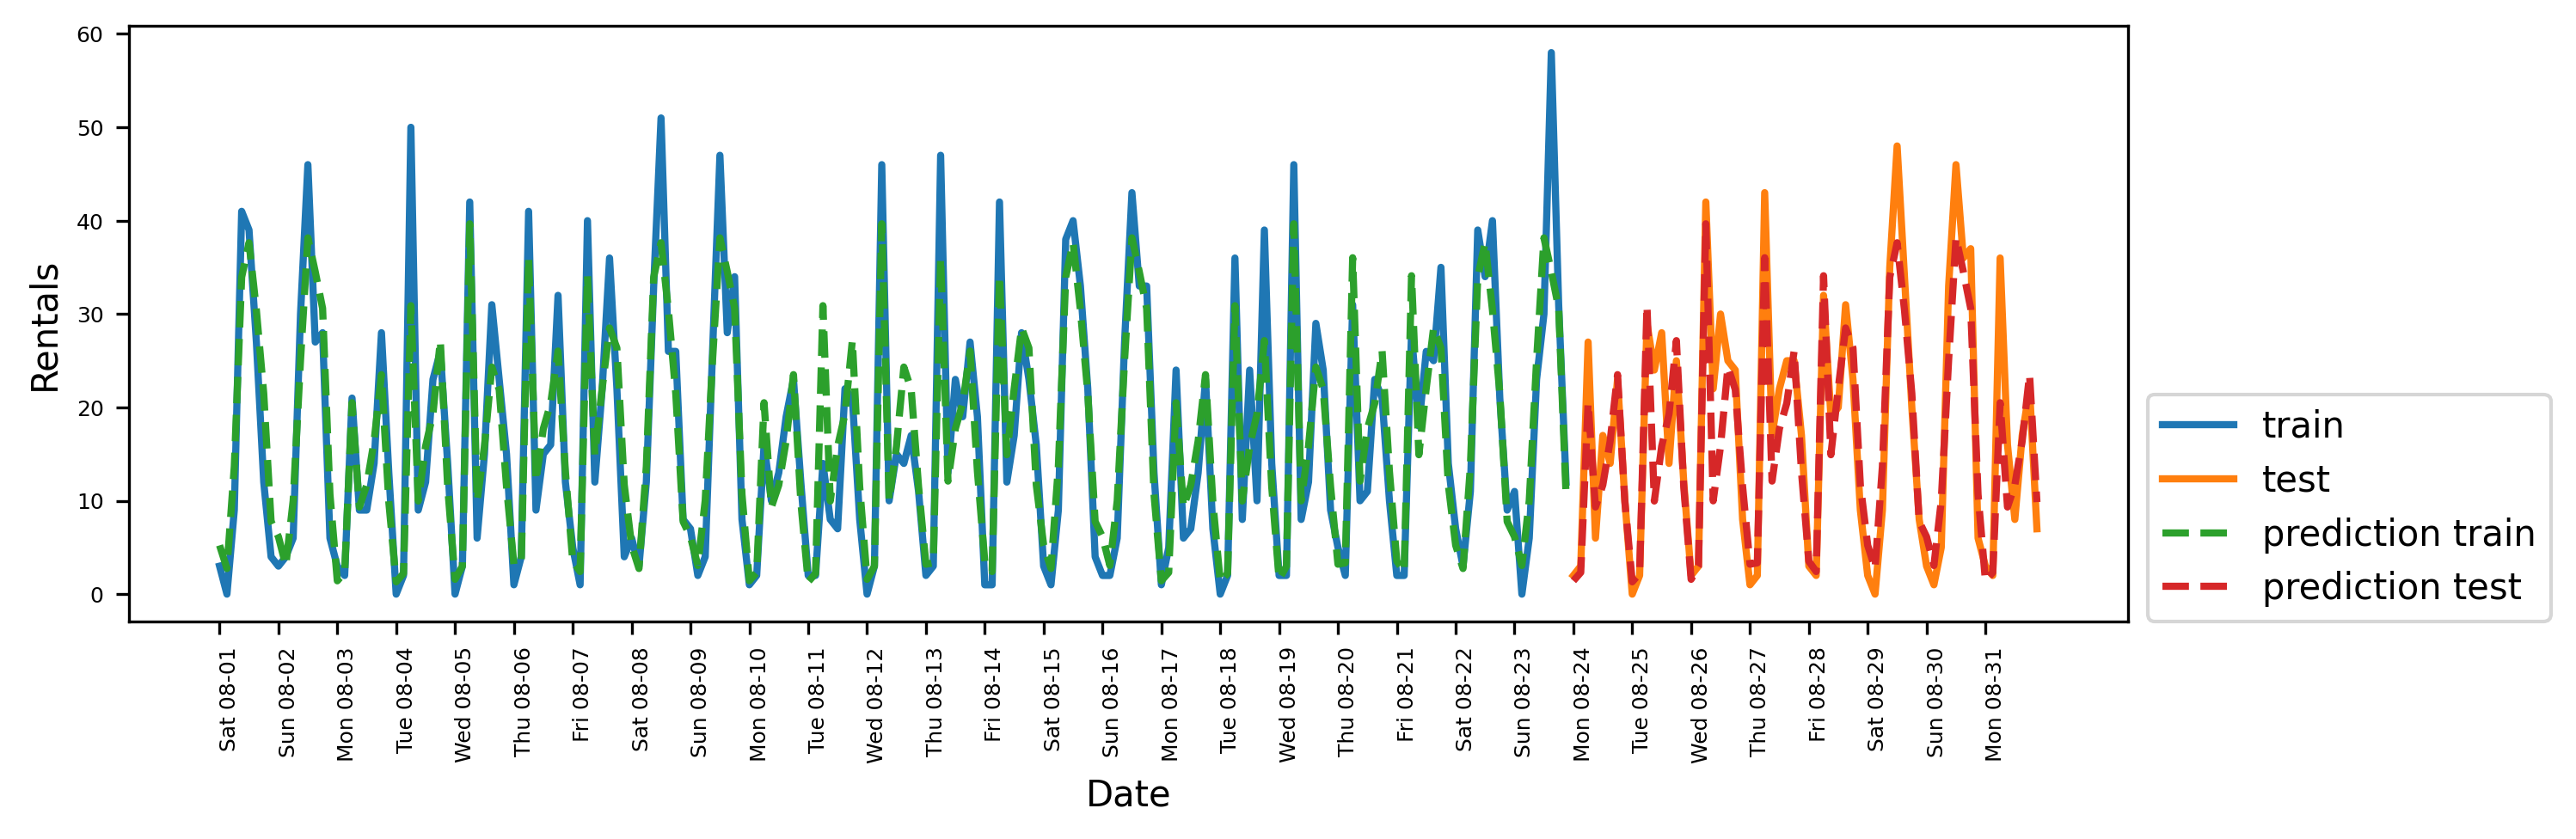

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)

X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
eval_on_features(X_hour_week_onehot_poly, y, Ridge())

In [13]:
print(X_hour_week_onehot_poly.shape)

(248, 120)


With this transformation, we finally get a model that is as good as the Random Forest cuts. A big advantage of this model is that very clearly is what it has learned: a coefficient for every day and every time.
We can simply plot the coefficients determined by the model, which is done with would not be possible in a Random Forest.